# Project Description

The bank is experiencing difficulties in retaining customers. Attracting new customers is expensive, and it is more cost-effective to retain those about whom some information is already available. It is necessary to analyze the bank's customers and identify segments of customers who are prone to leaving the bank.

**Research Goal:** Reduce customer churn.

**Objective:** Identify homogeneous customer segments that maximize coverage of problem areas.

**Client:** Marketing Department.

**Research Plan:**

1. [Data Loading and General Overview](#1)

2. [Data Preprocessing](#2)
- Handling missing values

3. [EDA](#3)
- Building a correlation matrix of features to identify the features influencing churn
- Creating histograms for each feature, segmented by churned and non-churned customers
- Comparing customer profiles based on mean, median, and modal values of the features
- Testing statistical hypotheses

4. [Customer Segmentation](#4)
- Selection of key features influencing churn
- Segmentation of churned customers
- Validation of segment size
- Prioritization of segments

5. [Recommendations for Customer Retention](#5)

## Data Loading and General Overview
<a id='1'></a>

In [1]:
%config InlineBackend.figure_format='retina'

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import MissingIndicator
from sklearn.impute import KNNImputer
from statistics import mode
from scipy import stats as st
from itertools import combinations

pd.set_option('display.max_colwidth', 0)

In [2]:
df = pd.read_csv('../data/updated_Data.csv')

display(df.head())
print(df.info())
display(df.describe())

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.0,Lakeshore,F,25,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Lakeshore,F,37,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Lakeshore,F,30,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Moonridge,F,51,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Moonridge,M,34,5,174.00,1,1,0,67353.16,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            10000 non-null  int64  
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(3), int64(7), object(2)
memory usage: 937.6+ KB
None


,USERID,score,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
count,10000.00000,10000.000000,10000.000000,10000.000000,7.705000e+03,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000
mean,171814.71260,848.409400,42.837100,2.627600,8.277943e+05,1.874100,0.680400,0.523500,1.478669e+05,0.182200
std,33708.23812,65.796312,12.128507,1.980836,1.980614e+06,0.799946,0.466345,0.499472,1.393885e+05,0.386029
min,94561.00000,642.000000,18.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,2.546300e+03,0.000000
25%,142810.25000,801.000000,34.000000,0.000000,2.955542e+05,1.000000,0.000000,0.000000,7.525190e+04,0.000000
50%,172728.00000,853.000000,40.000000,3.000000,5.242722e+05,2.000000,1.000000,1.000000,1.196581e+05,0.000000
75%,201261.75000,900.000000,51.000000,4.000000,9.807058e+05,2.000000,1.000000,1.000000,1.745005e+05,0.000000
max,229145.00000,1000.000000,86.000000,9.000000,1.191136e+08,5.000000,1.000000,1.000000,1.395064e+06,1.000000


In [3]:
print(df['city'].value_counts(), '\n')
print(df['gender'].value_counts())

Moonridge    5906
Lakeshore    2663
Driftwood    1431
Name: city, dtype: int64 

M    5008
F    4992
Name: gender, dtype: int64


The dataframe contains information on 10,000 customers with 11 features available. The `balance` column contains missing values, which we will handle in subsequent steps. Correct data types have been applied. No significant outliers were detected.

## Data Preprocessing
<a id='2'></a>

In [4]:
df.columns = df.columns.str.lower()
df.set_index('userid', inplace=True)

# encoding the gender column
to_replace = {'M' : 1, 'F' : 0}
df = df.replace(to_replace)

# encoding the city column by One Hot Encoding
df = pd.get_dummies(df, columns=['city'])
df.head()

,score,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,city_Driftwood,city_Lakeshore,city_Moonridge
userid,,,,,,,,,,,,,
183012,850.0,0,25,1,59214.82,2,0,1,75719.14,1,0,1,0
146556,861.0,0,37,5,850594.33,3,1,0,86621.77,0,0,1,0
120722,892.0,0,30,0,NaN,1,1,1,107683.34,0,0,1,0
225363,866.0,0,51,5,1524746.26,2,0,1,174423.53,1,0,0,1
157978,730.0,1,34,5,174.00,1,1,0,67353.16,1,0,0,1


In [5]:
df.duplicated().sum()

1

In [6]:
df = df.drop_duplicates()

### Handling missing values in the `balance` column 

In [7]:
# proportion of missing values.
df['balance'].isna().sum() / df.shape[0]

0.2294229422942294

In [8]:
# mean values of features for df with and without missing values.
pd.DataFrame(columns = ['df'], data = df.mean()) \
.join(pd.DataFrame(columns = ['df_without_NaNs'], data = df[df['balance'].notna()].mean()))

,df,df_without_NaNs
score,848.401340,843.739260
gender,0.500750,0.483452
age,42.838084,43.131343
equity,2.627863,3.395068
balance,827794.306510,827794.306510
products,1.874187,2.086178
credit_card,0.680368,0.640104
last_activity,0.523552,0.515769
est_salary,147843.483003,124501.872366
churn,0.182218,0.234783


In [9]:
df.query('balance == 0')

,score,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,city_Driftwood,city_Lakeshore,city_Moonridge
userid,,,,,,,,,,,,,
179831,730.0,1,18,0,0.0,2,1,1,64548.33,0,0,0,1
148456,813.0,1,20,2,0.0,2,1,0,23876.51,0,0,0,1


The proportion of churned customers in the dataframe with and without missing values differs by 5 percentage points. The features also show significant differences. Considering the high proportion of missing values, removing rows with NaN could distort the data. It can be assumed that missing balance information indicates a zero balance, and NaN should be replaced with zeros. However, the dataframe does contain records with an actual zero balance.
Possible reasons for the missing values:
- A technical error during data export;
- Data is intentionally hidden (e.g., these are VIP clients, and access to account balances is restricted);
- The customer does not have any open accounts in the bank;
- Customers might have recently opened accounts where balance information hasn't been updated yet, or their accounts are inactive.

Let’s check if there is a relationship between the balance and other features. Additionally, we will calculate the correlation between customer churn and the features to evaluate the importance of the balance feature for further analysis.

In [19]:
def plot_corr(feature):
    '''
      Visualizes correlations between a selected feature and other features,
      as well as correlations with a target feature churn
    '''
    plt.figure(figsize=(12,5))
    sns.heatmap(df.corr().loc[:,[feature]].drop(feature).sort_values(feature), 
            annot=True, fmt='.0%', cmap='vlag', center=0, cbar=False, ax=plt.subplot(1,2,1))
    sns.heatmap(df.corr().loc[:,['churn']].drop('churn').sort_values('churn'), 
            annot=True, fmt='.0%', cmap='vlag', center=0, cbar=False, ax=plt.subplot(1,2,2))
    plt.tight_layout()
    plt.show()

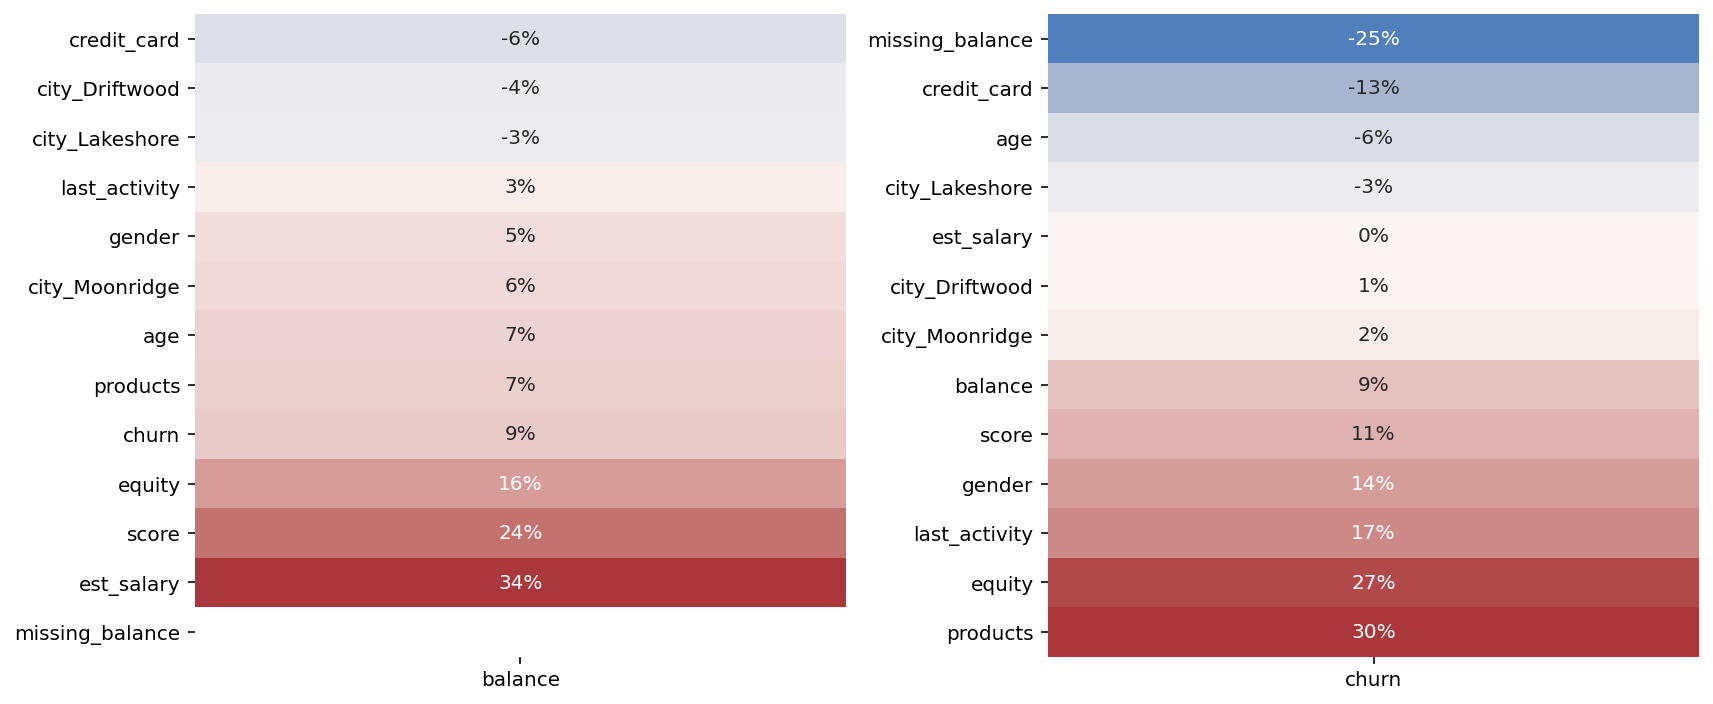

In [20]:
plot_corr('balance')

The balance feature shows a moderate positive correlation with salary and a weak correlation with credit scoring and property status. There is virtually no correlation with churn. Overall, this feature could potentially be removed by dropping the column.
However, we can hypothesize that the missing values are not random. Therefore, we could introduce a missing balance indicator as a new feature and analyze its impact on churn.

### Adding a Missing Balance Indicator

In [12]:
# using MissingIndicator, a row with a missing value will be marked as 1
indicator = MissingIndicator()
missing_balance = indicator.fit_transform(df)
df['missing_balance'] = missing_balance

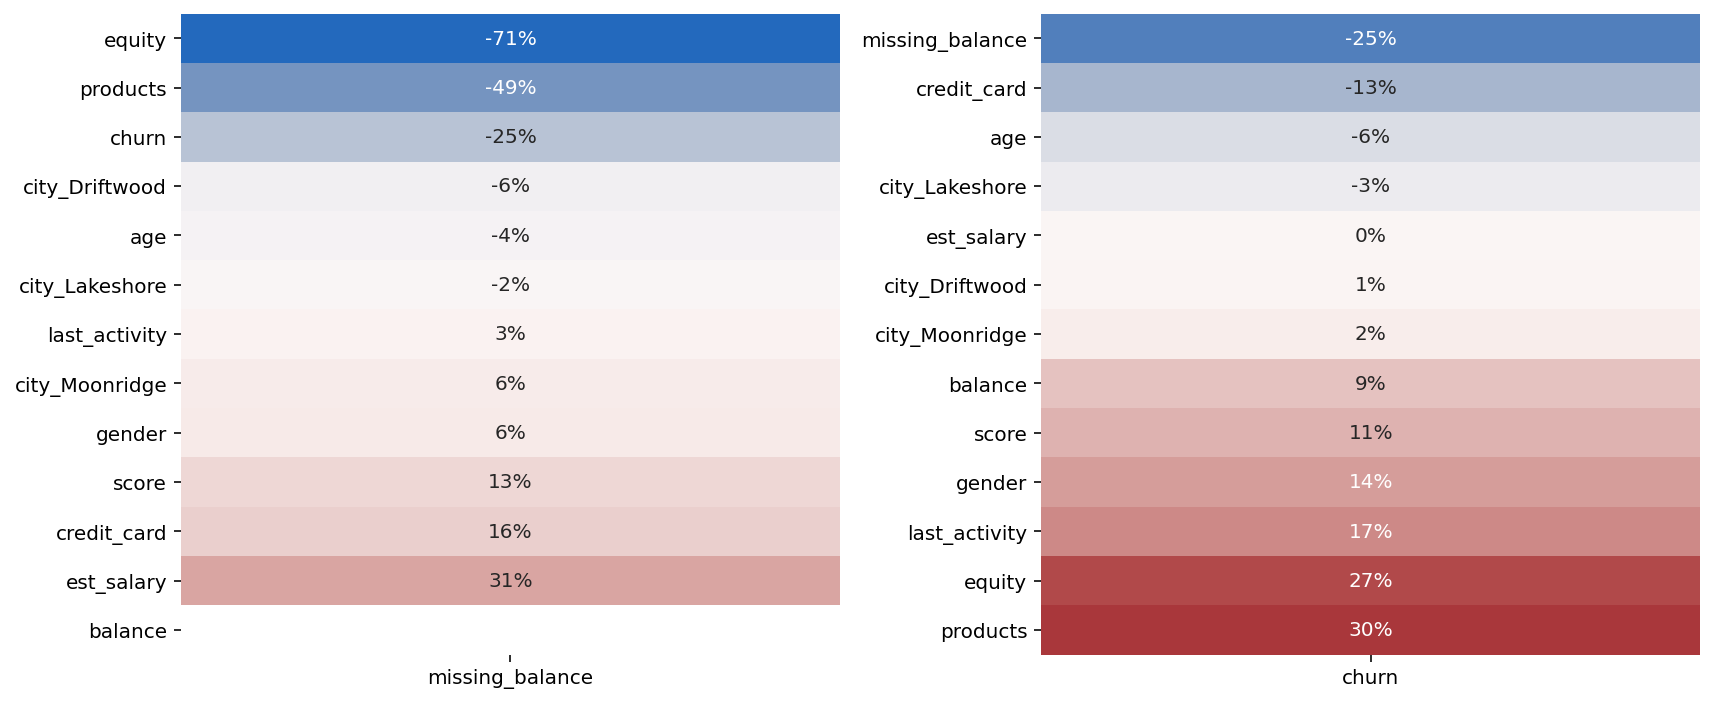

In [21]:
plot_corr('missing_balance')

As we can see, there is a strong negative correlation between `equity` (property status) and a missing balance: the lower the client's asset evaluation, the more often balance information is unavailable. Additionally, there is a noticeable negative correlation with the number of products. It is possible that such clients do not actually have a checking account at the bank, use a limited number of products (e.g., only a credit card), or are inactive/new clients. Interestingly, the presence of a missing balance is negatively correlated with churn.

Considering that the balance feature has some dependence on other features, we will try to predict the missing values using the K-Nearest Neighbors (KNN) algorithm. The algorithm will find the rows most similar to the one with the missing balance based on other features, compute the average balance of these rows, and use this average to fill in the missing values.

### Replacement with K-Nearest Neighbors

In [14]:
impute = KNNImputer(n_neighbors=5)
prediction = impute.fit_transform(df)

df_pred = pd.DataFrame(columns=df.columns, data=prediction, index=df.index)
print(df_pred.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9999 entries, 183012 to 96267
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   score            9999 non-null   float64
 1   gender           9999 non-null   float64
 2   age              9999 non-null   float64
 3   equity           9999 non-null   float64
 4   balance          9999 non-null   float64
 5   products         9999 non-null   float64
 6   credit_card      9999 non-null   float64
 7   last_activity    9999 non-null   float64
 8   est_salary       9999 non-null   float64
 9   churn            9999 non-null   float64
 10  city_Driftwood   9999 non-null   float64
 11  city_Lakeshore   9999 non-null   float64
 12  city_Moonridge   9999 non-null   float64
 13  missing_balance  9999 non-null   float64
dtypes: float64(14)
memory usage: 1.1 MB
None


In [15]:
# convert the data type of all columns, excluding the columns 'balance' and 'est_salary', to integers
df_pred[df_pred.columns.difference(['balance', 'est_salary'])] = \
df_pred[df_pred.columns.difference(['balance', 'est_salary'])].astype(int)

Let's compare the distributions of balance before and after handling missing values:

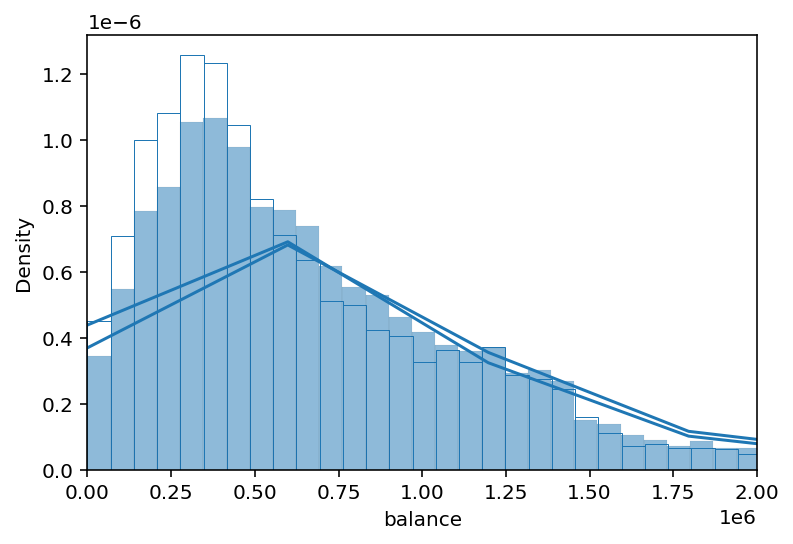

In [17]:
fig, ax = plt.subplots()
sns.histplot(x='balance', data=df, stat='density', ax=ax, fill=False, kde=True)
sns.histplot(x='balance', data=df_pred, stat='density', ax=ax, kde=True)
plt.xlim(0,2000000)
plt.show()

Handling missing values did not lead to significant changes in the nature of the distribution.

## EDA
<a id='3'></a>

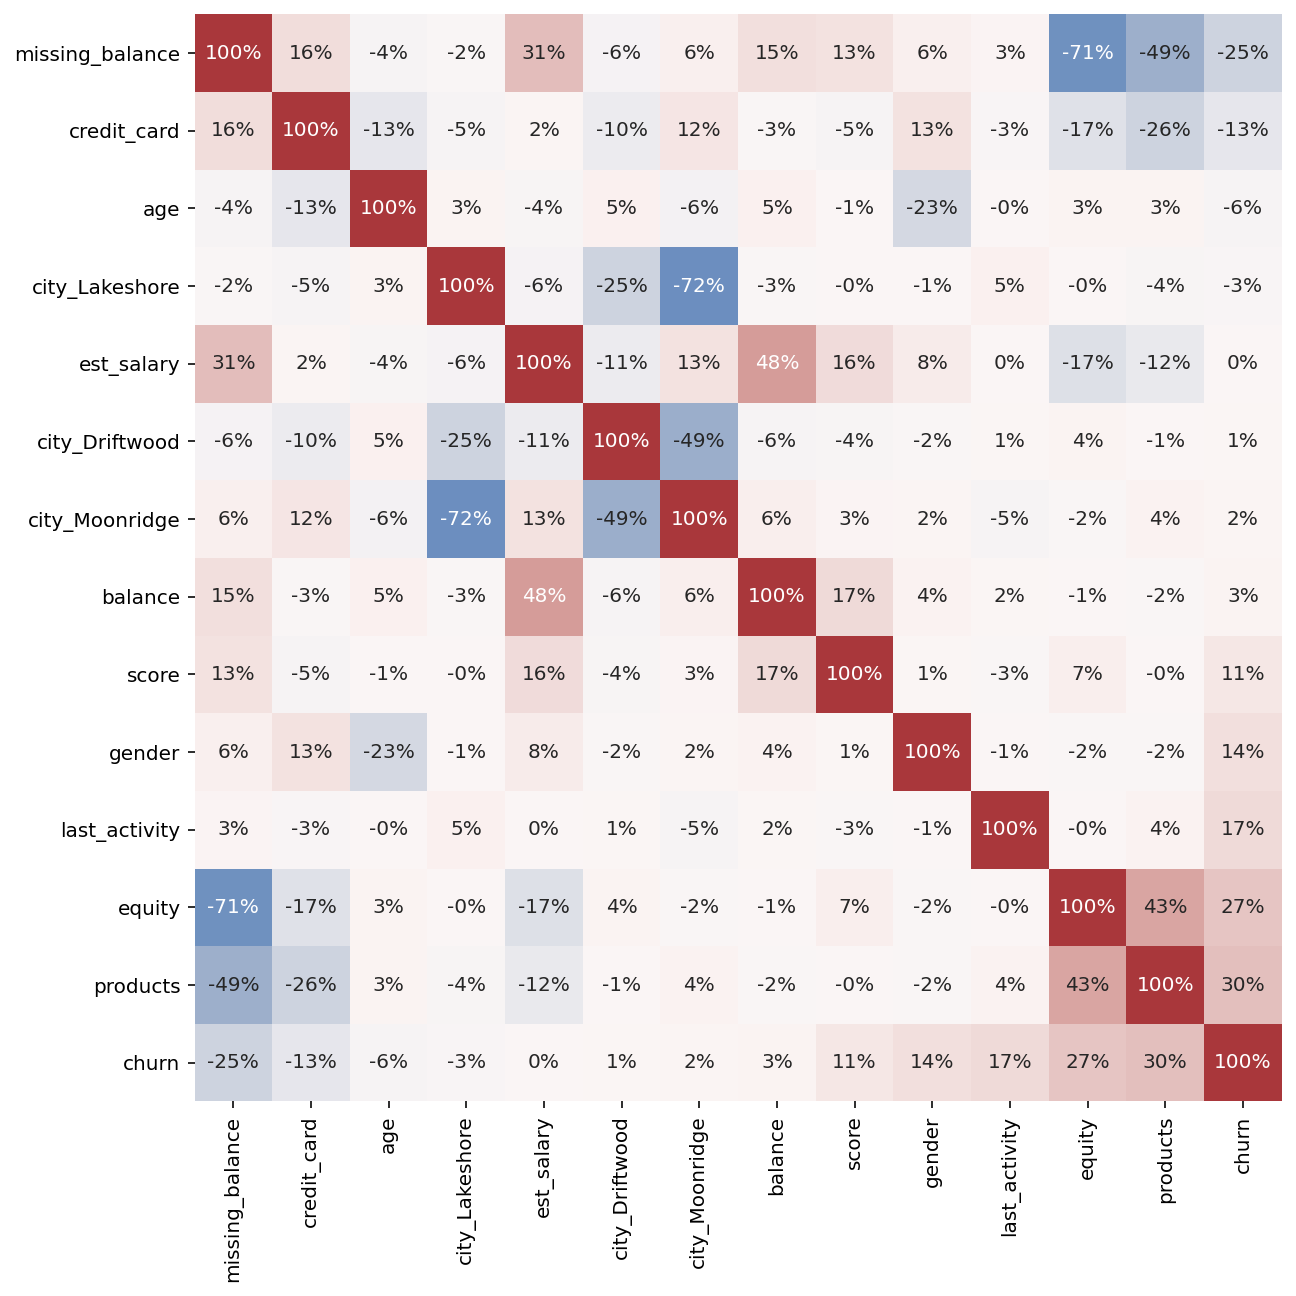

In [25]:
# correlation matrix after handling missing values
plt.figure(figsize=(10,10))
sns.heatmap(df_pred.corr().sort_values('churn').T.sort_values('churn').T, 
            annot=True, fmt='.0%', cmap='vlag', center=0, cbar=False, square=True)

plt.show()

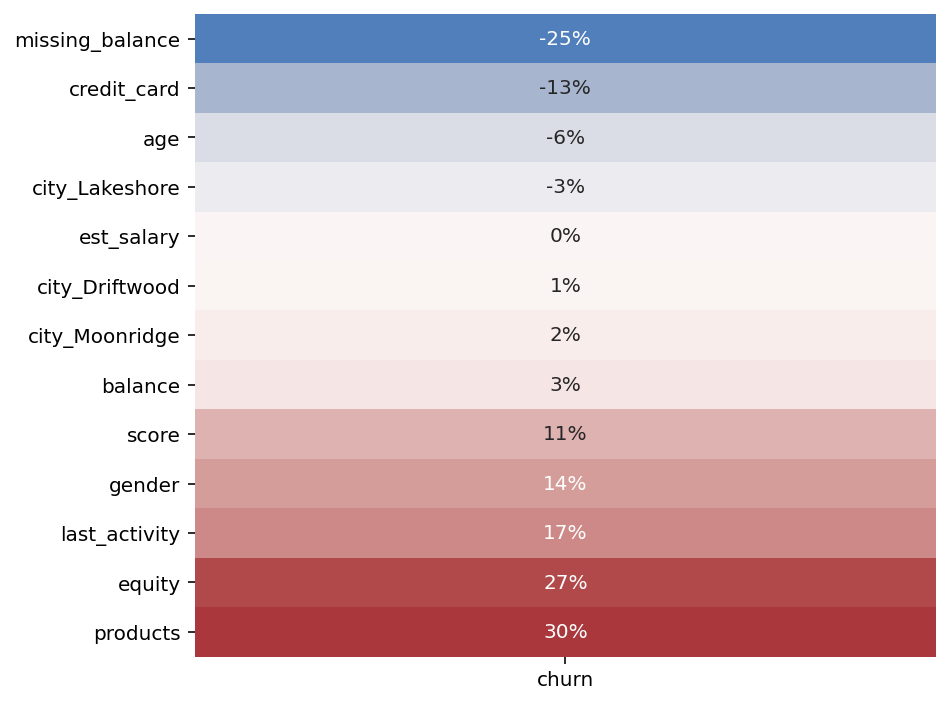

In [24]:
# correlation matrix of features affecting churn after handling missing values
plt.figure(figsize=(12,5))
sns.heatmap(df_pred.corr().loc[:,['churn']].drop('churn').sort_values('churn'), 
            annot=True, fmt='.0%', cmap='vlag', center=0, cbar=False, ax=plt.subplot(1,2,1))
plt.tight_layout()
plt.show()

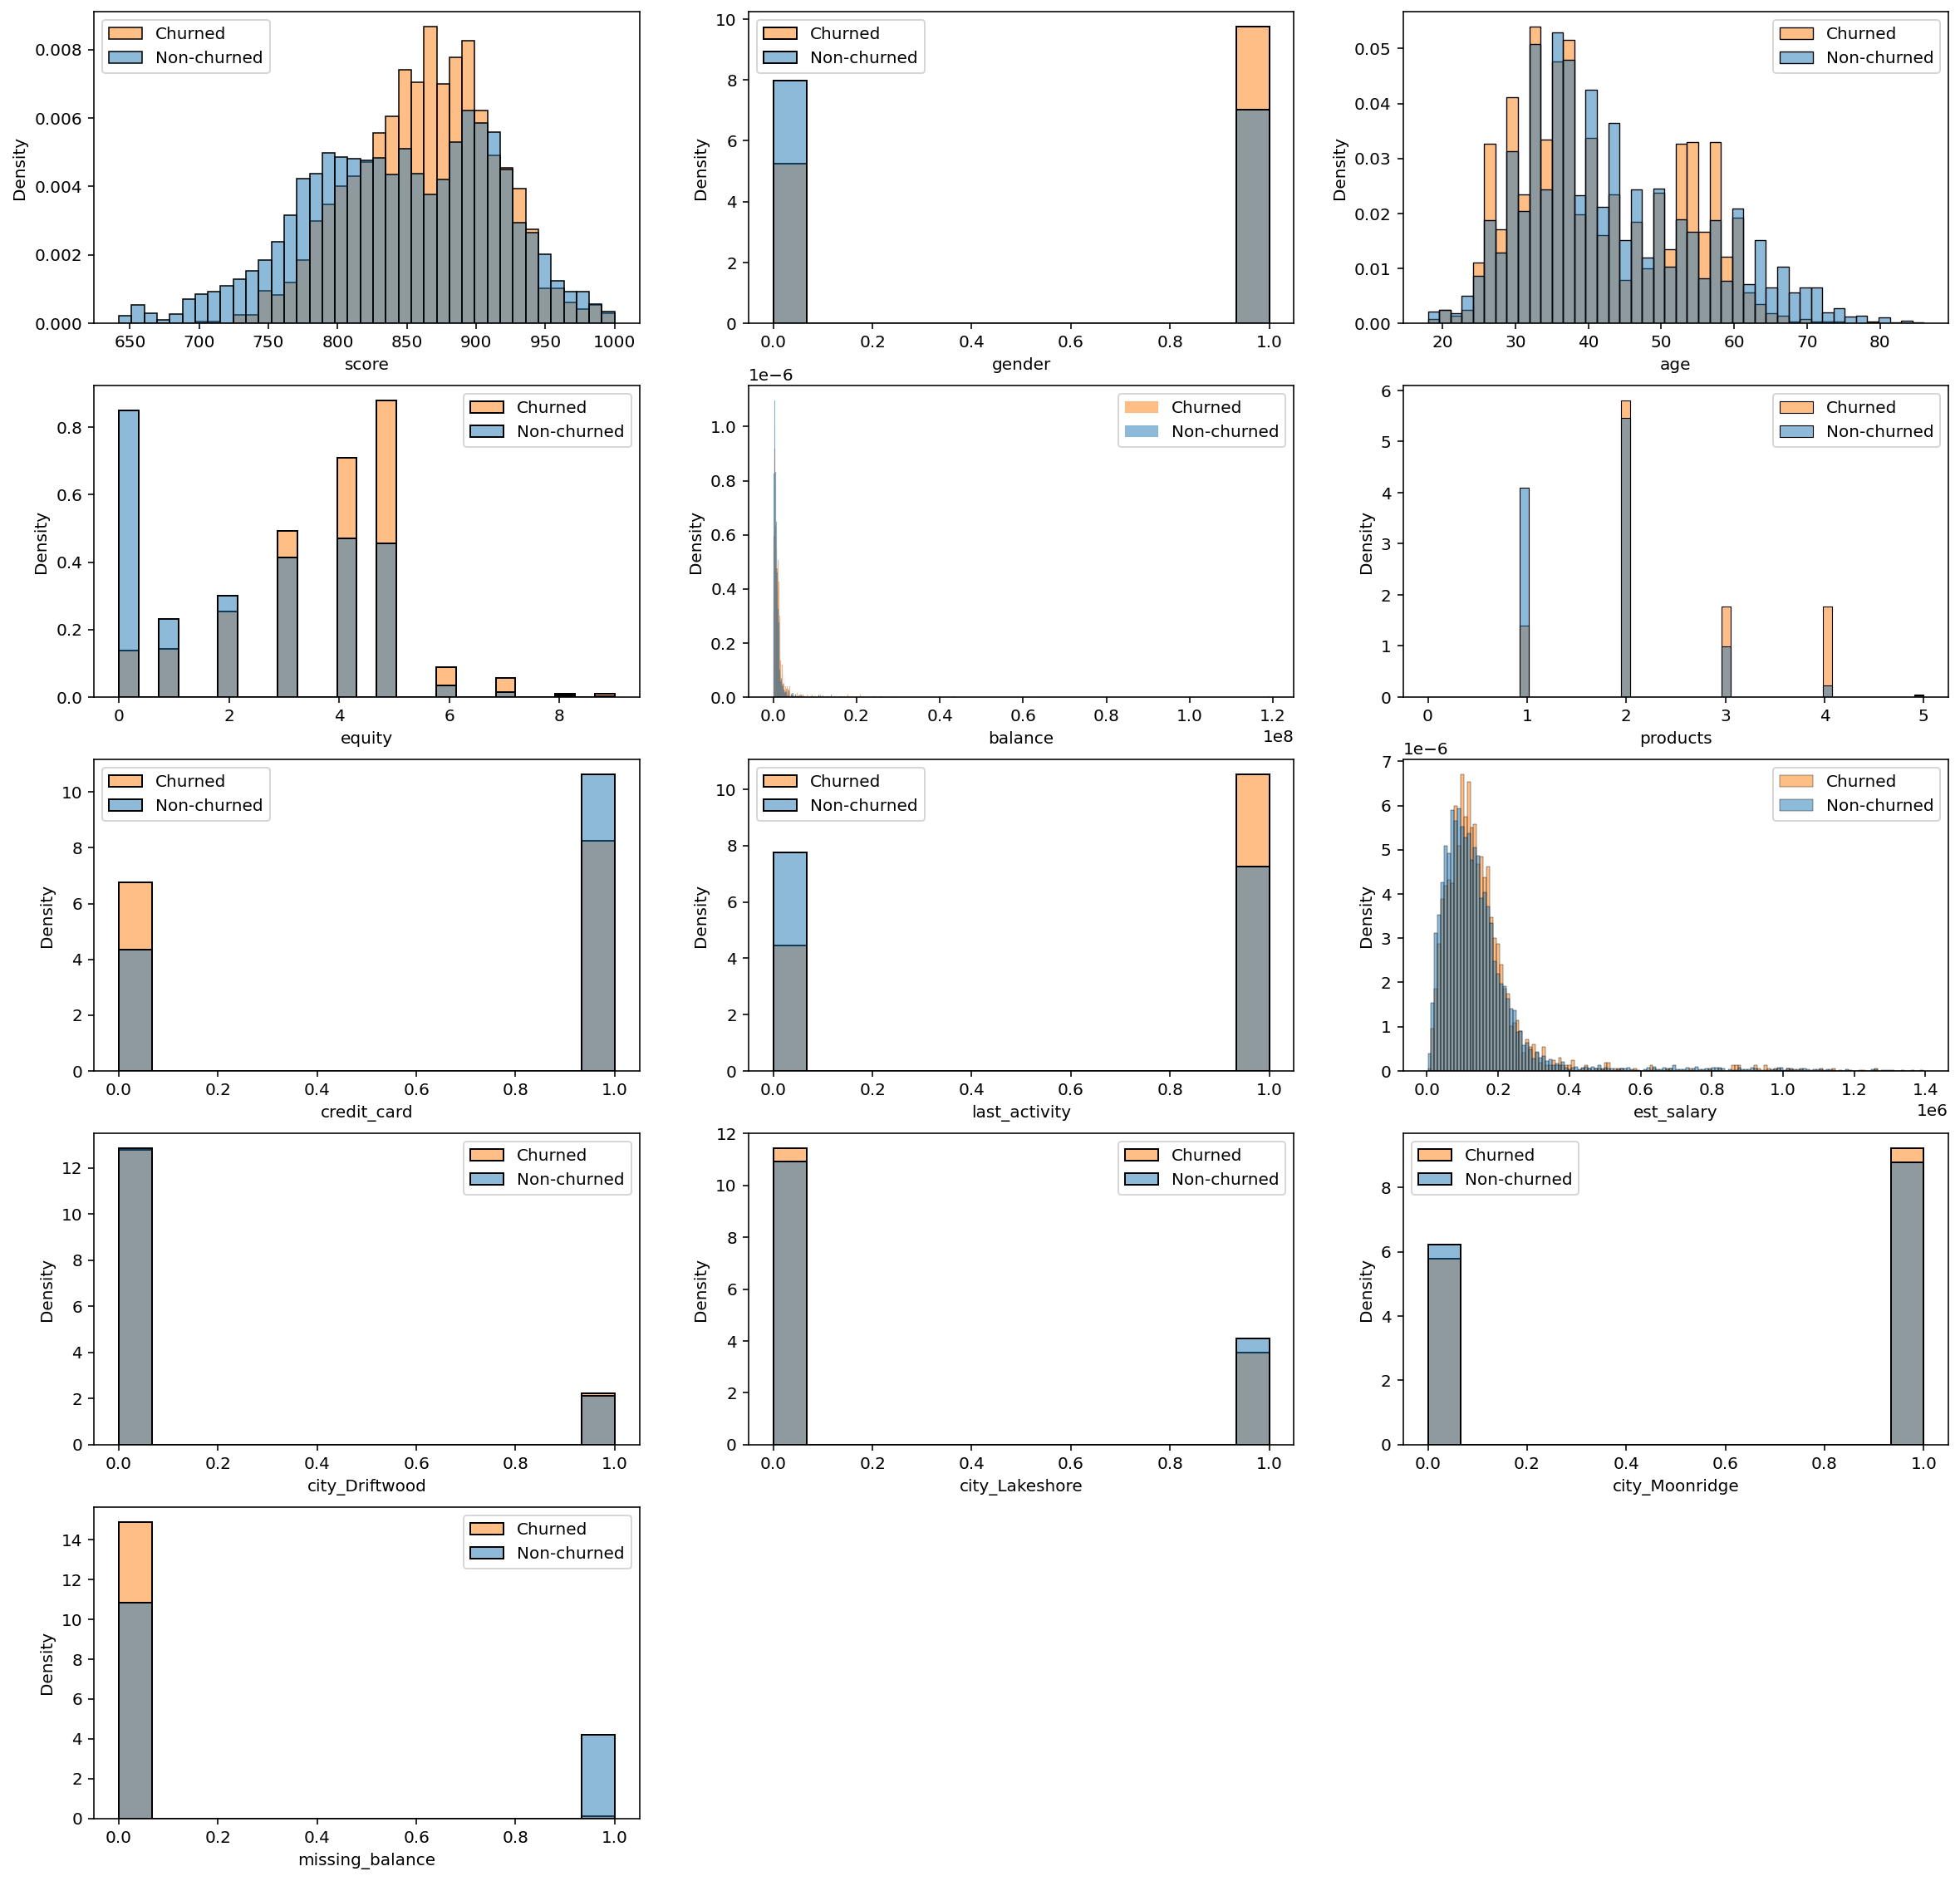

In [27]:
# histograms for each feature segmented by churned and non-churned customers
plt.figure(figsize=(20,20))

for i, feature in enumerate(df_pred.drop('churn', axis=1).columns):
    sns.histplot(x=feature, 
                 data=df_pred, 
                 stat='density', 
                 hue='churn', 
                 common_norm=False, 
                 ax=plt.subplot(5, 3, i+1))
    plt.legend(labels=['Churned', 'Non-churned'])

plt.show()

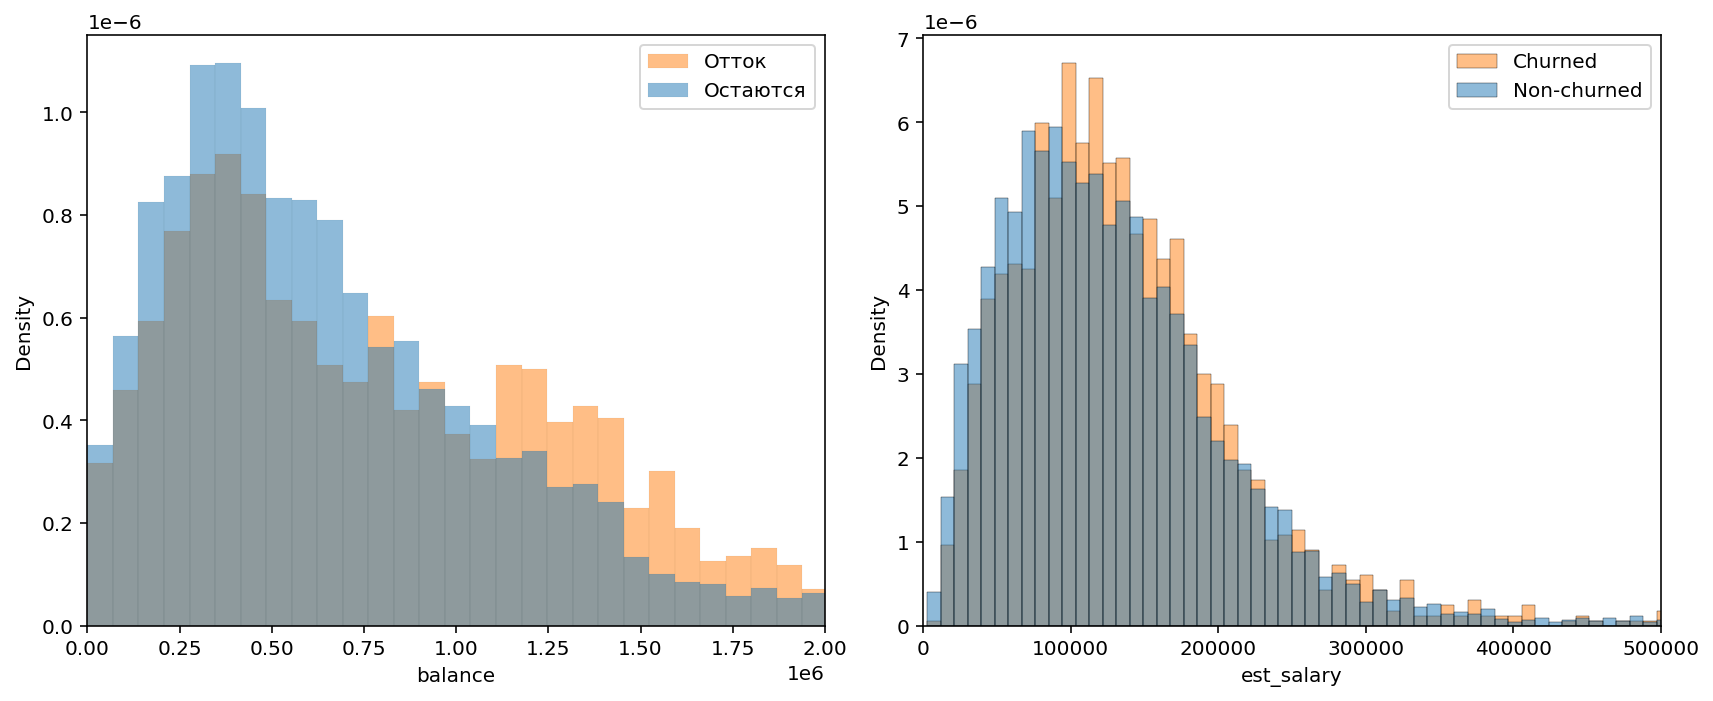

In [28]:
# distribution of balance and income (scaled)
plt.figure(figsize=(12,5))

sns.histplot(x='balance', 
             data=df_pred, 
             stat='density', 
             hue='churn', 
             common_norm=False, 
             ax=plt.subplot(1, 2, 1))
plt.legend(labels=['Отток', 'Остаются'])
plt.xlim(0,2000000)

sns.histplot(x='est_salary', 
             data=df_pred, 
             stat='density', 
             hue='churn', 
             common_norm=False, 
             ax=plt.subplot(1, 2, 2))
plt.legend(labels=['Churned', 'Non-churned'])
plt.xlim(0,500000)

plt.tight_layout()
plt.show()

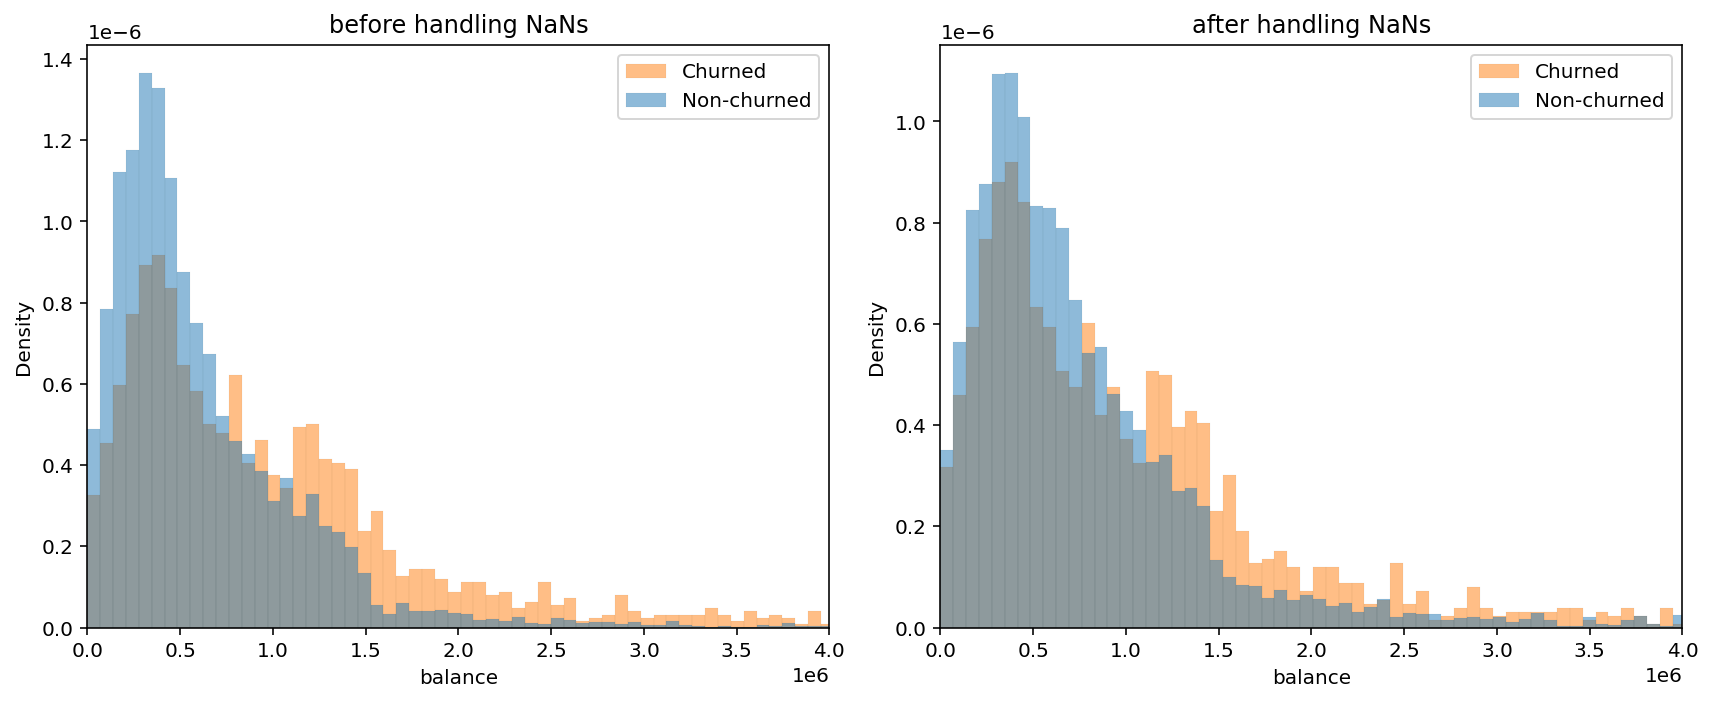

In [29]:
# distribution of balance before and after handling missing values
plt.figure(figsize=(12,5))

sns.histplot(x='balance', 
             data=df, 
             stat='density', 
             hue='churn', 
             common_norm=False, 
             ax=plt.subplot(1, 2, 1)).set(title='before handling NaNs')
plt.legend(labels=['Churned', 'Non-churned'])
plt.xlim(0,4000000)

sns.histplot(x='balance', 
             data=df_pred, 
             stat='density', 
             hue='churn', 
             common_norm=False, 
             ax=plt.subplot(1, 2, 2)).set(title='after handling NaNs')
plt.legend(labels=['Churned', 'Non-churned'])
plt.xlim(0,4000000)

plt.tight_layout()
plt.show()

Let's compare the mean and mode values of features for churned and non-churned customers. For the features `equity` and `products`, we will calculate the mode, and for the others, the mean.

In [32]:
def portrait(features, statistic):
    if statistic == 'median':
        result = pd.DataFrame(columns = ['Churned'], 
             data = df_pred.query('churn == 1')[features]
             .median()).round(2) \
        .join(pd.DataFrame(columns = ['Non-churned'], 
             data = df_pred.query('churn == 0')[features]
             .median()).round(2))
    elif statistic == 'mean':
        result = pd.DataFrame(columns = ['Churned'], 
             data = df_pred.query('churn == 1')[features]
             .mean()).round(2) \
        .join(pd.DataFrame(columns = ['Non-churned'], 
             data = df_pred.query('churn == 0')[features]
             .mean()).round(2))
    else:
        result = pd.DataFrame(columns = ['Churned'], 
             data = [mode(df_pred.query('churn == 1')[i]) for i in features],
             index=features) \
        .join(pd.DataFrame(columns = ['Non-churned'], 
             data = [mode(df_pred.query('churn == 0')[i]) for i in features],
             index=features))
    return result

In [33]:
col_for_median = df_pred.columns.difference(['equity', 'products']).tolist()
temp_1 = portrait(col_for_median, 'mean')
temp_2 = portrait(['equity', 'products'], 'mode')
pd.concat([temp_1,temp_2])

,Churned,Non-churned
age,41.40,43.16
balance,1139124.01,960465.09
churn,1.00,0.00
city_Driftwood,0.15,0.14
city_Lakeshore,0.24,0.27
city_Moonridge,0.62,0.59
credit_card,0.55,0.71
est_salary,148199.98,147764.05
gender,0.65,0.47
last_activity,0.70,0.48


As we can see, there are differences across several features. It is worth noting that among customers with a missing balance, there are almost no churned customers. Previously, it was hypothesized that such customers primarily use only a credit card, which is why they do not have a checking account at the bank. 

Let’s look at a graph to see how the number of products correlates with the presence of a credit card for these customers.

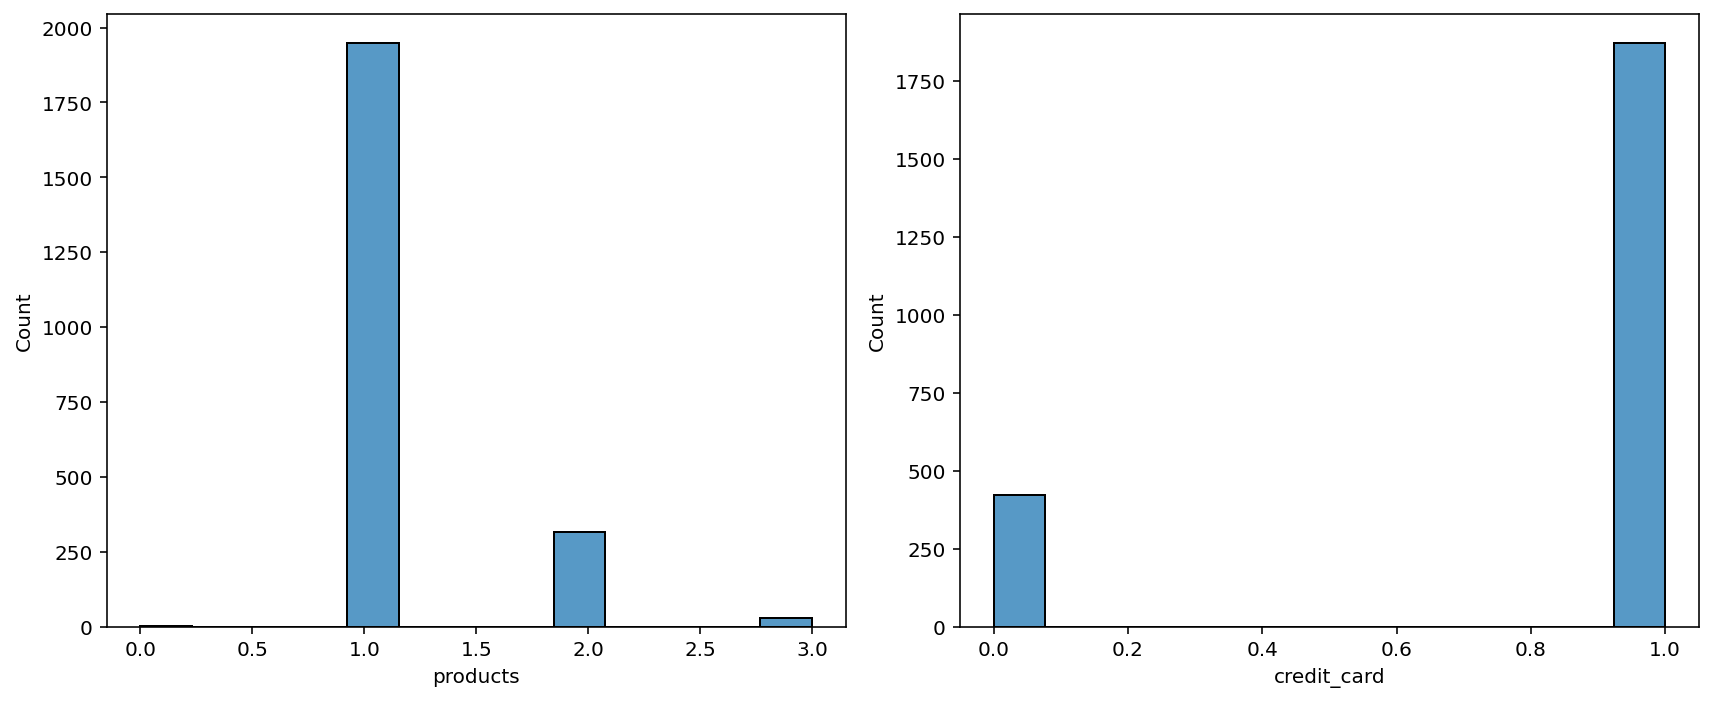

In [34]:
plt.figure(figsize=(12,5))
sns.histplot(x='products', data=df_pred.query('missing_balance == 1'), ax=plt.subplot(1,2,1))
sns.histplot(x='credit_card', data=df_pred.query('missing_balance == 1'), ax=plt.subplot(1,2,2))
plt.tight_layout()
plt.show()

The hypothesis is likely correct — most of these customers typically have only a credit card.

The following churn boundaries can be identified:
- score >= 840 and score <= 910,
- equity >= 3, 
- balance >= 1130000, 
- products >= 2, 
- credit_card == 0, 
- missing_balance == 0, 
- (age >= 25 and age <= 34) or (age >= 52 and age <= 60)

### Statistical Hypothesis Testing

Let’s check whether the differences in income and the presence of a credit card are statistically significant. As observed earlier, the differences in salary can be quite large (salaries over 400,000 are present). Therefore, it is appropriate to apply the non-parametric Mann-Whitney test.

#### Hypothesis testing for income differences between churned and retained customers

Hypotheses:
- Н0 - There is no significant difference in income between customers who churned and those who stayed.
- Н1 - There is a significant difference in income between customers who churned and those who stayed.

In [35]:
alpha = .05

result = st.mannwhitneyu(
    df_pred.query('churn == 1')['est_salary'], 
    df_pred.query('churn == 0')['est_salary'])

print(result.pvalue)

0.0002499111605569152


We reject the null hypothesis - income levels differ significantly between the two groups.

#### Testing the hypothesis about differences in credit card usage between churned and non-churned customers

Hypotheses:
- Н0 - The proportions of churned and non-churned customers who have a credit card are not different;
- Н1 - The proportion of churned customers with a credit card is smaller than that of non-churned customers

In [36]:
alpha = .05

result = st.ttest_ind(
    df_pred.query('churn == 1')['credit_card'], 
    df_pred.query('churn == 0')['credit_card'], 
    equal_var = False,
    alternative = 'less'
)

print(result.pvalue)

1.8094723805582136e-35


The probability that the proportions are the same is extremely low. It can be concluded that churned customers are less likely to use a credit card. The table above also shows that loyal customers are more likely to have a credit card.

## Customer Segmentation
<a id='4'></a>

Let’s define the key features influencing churn::
- products
- equity
- credit_card
- missing_balance (we will separately identify segments without this feature)

When building segments, we will also consider the following features (due to clear differences between customer groups):
- score
- age
- balance

In [37]:
# churn boundaries
queries = {'score': 'score >= 840 and score <= 910',
          'equity': 'equity >= 3', 
          'balance': 'balance >= 1130000', 
          'products': 'products >= 2', 
          'credit_card': 'credit_card == 0', 
          'missing_balance': 'missing_balance == 0', 
           'age': '((age >= 25 and age <= 34) or (age >= 52 and age <= 60))'}

In [38]:
def segmentation(features):
    
    '''
    The function accepts features that will be combined later to find the optimal combination. 
    It returns arrays for further construction of a DataFrame:
    
    keys - lists the features in the format 'equity + balance + products', 
    making it clear which features are being combined.
    size - the number of clients selected based on the features
    churn_rate - the churn rate for the selected clients 
    churn_rate_other - the churn rate for clients who do not fall within the defined boundaries of the features
    '''
    
    values = [queries[i] for i in features]
    values = ' and '.join(values)
    keys = ' + '.join(features)
    new_query = {keys: values}
    
    size = df_pred.query(values).shape[0]
    churn_rate = round(df_pred.query(values)['churn'].mean(), 2)
    churn_index = df_pred.query(values).index
    staying_index = df_pred.index.difference(churn_index)
    churn_rate_other = round(df_pred.loc[staying_index, 'churn'].mean(), 2)
    
    return keys, size, churn_rate, churn_rate_other

In [39]:
def get_segments(number_of_features_to_combine):
    
    '''
    Passing the number of features to combine into the function.
    The function iterates through all possible combinations of features from the queries variable.
    For each combination, it retrieves data arrays from the segmentation function,
    which are then used to construct a DataFrame.
    '''

    features = list(queries.keys())
    features_combinations = combinations(features, number_of_features_to_combine)
    list_of_features = [i for i in features_combinations]

    keys, size, churn_rate, churn_rate_other =[],[],[],[]

    for i in list_of_features:
    
        k, s, c_r, c_r_o = segmentation(list(i))
    
        keys.append(k)
        size.append(s)
        churn_rate.append(c_r)
        churn_rate_other.append(c_r_o)

    result = pd.DataFrame({
        'Feature': keys,
        'Num_of_clients': size,
        'Churn_rate': churn_rate,
        'Churn_rate_others': churn_rate_other
    })
    
    return result

In [42]:
def segments_scoring(result):
    
    '''
    The function accepts a DataFrame containing all combinations of features generated by the get_segments function.
    Columns are assigned ratings from 1 to 5, taking into account an adjustment coefficient 
    (determined experimentally, reflecting the approximate weight of the metric).
    '''
    
    result['clients_score'] = pd.qcut(
        result['Num_of_clients'], 
        q=5, labels=[i*0.9 for i in range(1,6)])
    result['churn_score'] = pd.cut(
        result['Churn_rate'], 
        bins=5, labels=[i*1.5 for i in range(1,6)])
    result['churn_other_score'] = pd.cut(
        result['Churn_rate_others'], 
        bins=5, labels=[-i*0.5 for i in range(1,6)])
    result['score'] = result[['clients_score', 'churn_score', 'churn_other_score']].sum(axis=1)
    
    return result

We will segment clients using combinations of 2 to 5 features (including the `missing_balance` feature) and display the top 5 segments for each iteration.

In [43]:
total_result_with_mb=[]
for i in range(2,6):
    result = get_segments(i)
    seg_scoring = segments_scoring(result)
    display(seg_scoring.sort_values('score', ascending=False).head())
    total_result_with_mb.append(seg_scoring)

,Feature,Num_of_clients,Churn_rate,Churn_rate_others,clients_score,churn_score,churn_other_score,score
13,balance + missing_balance,1532,0.42,0.14,1.8,7.5,-2.0,7.3
11,balance + products,1506,0.41,0.14,1.8,7.5,-2.0,7.3
6,equity + balance,1435,0.42,0.14,1.8,7.5,-2.0,7.3
20,missing_balance + age,3201,0.31,0.12,4.5,3.0,-1.5,6.0
16,products + missing_balance,6314,0.25,0.06,4.5,1.5,-0.5,5.5


,Feature,Num_of_clients,Churn_rate,Churn_rate_others,clients_score,churn_score,churn_other_score,score
17,equity + balance + missing_balance,1435,0.42,0.14,3.6,4.5,-2.0,6.1
14,score + missing_balance + age,1287,0.41,0.15,3.6,4.5,-2.0,6.1
26,balance + products + missing_balance,1380,0.44,0.14,3.6,4.5,-2.0,6.1
15,equity + balance + products,1296,0.45,0.14,3.6,4.5,-2.0,6.1
3,score + equity + missing_balance,2405,0.34,0.13,4.5,3.0,-1.5,6.0


,Feature,Num_of_clients,Churn_rate,Churn_rate_others,clients_score,churn_score,churn_other_score,score
32,balance + products + missing_balance + age,482,0.60,0.16,1.8,7.5,-1.5,7.8
0,score + equity + balance + products,545,0.54,0.16,2.7,6.0,-1.5,7.2
19,score + credit_card + missing_balance + age,512,0.54,0.16,2.7,6.0,-1.5,7.2
17,score + products + credit_card + age,509,0.54,0.16,2.7,6.0,-1.5,7.2
21,equity + balance + products + missing_balance,1296,0.45,0.14,4.5,3.0,-0.5,7.0


,Feature,Num_of_clients,Churn_rate,Churn_rate_others,clients_score,churn_score,churn_other_score,score
17,equity + balance + products + missing_balance + age,451,0.59,0.16,3.6,4.5,-1.0,7.1
2,score + equity + balance + products + age,190,0.68,0.17,0.9,7.5,-2.0,6.4
12,score + balance + products + missing_balance + age,204,0.69,0.17,0.9,7.5,-2.0,6.4
9,score + equity + credit_card + missing_balance + age,433,0.56,0.17,3.6,4.5,-2.0,6.1
4,score + equity + balance + credit_card + age,125,0.72,0.18,0.9,7.5,-2.5,5.9


We will also look at the top 5 segments without considering the `missing_balance` feature.

In [44]:
queries = {'score': 'score >= 840 and score <= 910',
          'equity': 'equity >= 3', 
          'balance': 'balance >= 1130000', 
          'products': 'products >= 2', 
          'credit_card': 'credit_card == 0', 
           'age': '((age >= 25 and age <= 34) or (age >= 52 and age <= 60))'}

In [45]:
total_result_without_mb=[]
for i in range(2,6):
    result = get_segments(i)
    seg_scoring = segments_scoring(result)
    display(seg_scoring.sort_values('score', ascending=False).head())
    total_result_without_mb.append(seg_scoring)

,Feature,Num_of_clients,Churn_rate,Churn_rate_others,clients_score,churn_score,churn_other_score,score
9,balance + products,1506,0.41,0.14,2.7,7.5,-2.0,8.2
5,equity + balance,1435,0.42,0.14,1.8,7.5,-2.0,7.3
0,score + equity,2405,0.34,0.13,3.6,4.5,-1.5,6.6
8,equity + age,2336,0.35,0.13,3.6,4.5,-1.5,6.6
13,products + age,2778,0.31,0.13,4.5,3.0,-1.5,6.0


,Feature,Num_of_clients,Churn_rate,Churn_rate_others,clients_score,churn_score,churn_other_score,score
10,equity + balance + products,1296,0.45,0.14,4.5,4.5,-0.5,8.5
17,balance + products + age,533,0.54,0.16,1.8,7.5,-2.0,7.3
12,equity + balance + age,492,0.57,0.16,0.9,7.5,-2.0,6.4
15,equity + credit_card + age,901,0.46,0.15,2.7,4.5,-1.0,6.2
18,balance + credit_card + age,345,0.54,0.17,0.9,7.5,-2.5,5.9


,Feature,Num_of_clients,Churn_rate,Churn_rate_others,clients_score,churn_score,churn_other_score,score
11,equity + balance + products + age,451,0.59,0.16,2.7,6.0,-1.0,7.7
12,equity + balance + credit_card + age,283,0.63,0.17,1.8,7.5,-2.0,7.3
0,score + equity + balance + products,545,0.54,0.16,3.6,4.5,-1.0,7.1
9,score + products + credit_card + age,509,0.54,0.16,3.6,4.5,-1.0,7.1
2,score + equity + balance + age,209,0.65,0.17,0.9,7.5,-2.0,6.4


,Feature,Num_of_clients,Churn_rate,Churn_rate_others,clients_score,churn_score,churn_other_score,score
1,score + equity + balance + products + age,190,0.68,0.17,1.8,6.0,-0.5,7.3
5,equity + balance + products + credit_card + age,281,0.63,0.17,2.7,4.5,-0.5,6.7
2,score + equity + balance + credit_card + age,125,0.72,0.18,0.9,7.5,-2.5,5.9
4,score + balance + products + credit_card + age,135,0.70,0.18,0.9,7.5,-2.5,5.9
3,score + equity + products + credit_card + age,425,0.57,0.17,4.5,1.5,-0.5,5.5


We will select the most significant segments in terms of the number of clients and churn rate (with and without the `missing_balance` feature).

In [46]:
top_segments = pd.concat([total_result_with_mb[2].loc[21], 
                          total_result_with_mb[1].loc[14], 
                          total_result_without_mb[1].loc[15]],
                        axis=1).T.reset_index(drop=True)
top_segments

,Feature,Num_of_clients,Churn_rate,Churn_rate_others,clients_score,churn_score,churn_other_score,score
0,equity + balance + products + missing_balance,1296,0.45,0.14,4.5,3.0,-0.5,7.0
1,score + missing_balance + age,1287,0.41,0.15,3.6,4.5,-2.0,6.1
2,equity + credit_card + age,901,0.46,0.15,2.7,4.5,-1.0,6.2


#### We can define three churn segments

Segment 0:
- Property evaluation of at least 3
- Balance amount of at least 1.13 million
- Number of products at least 22
- No missing balance label

Segment 1:
- Credit score between 840 and 910
- No missing balance label
- Age between 25-34 or 52-60

Segment 2:
- Property evaluation of at least 3
- No credit card
- Age between 25-34 or 52-60

## Recommendations for Customer Retention
<a id='5'></a>

**General Observations**

From the analysis, it appears that churn is more prevalent among wealthier clients with:
- Higher-than-average balances.
- Good credit scores.
- Ownership of multiple financial products.
- Higher property evaluations.

Additionally:
- Missing values in the balance field were assumed to indicate the absence of a checking account. Clients in this category typically own just one product, most often a credit card, and exhibit a lower churn rate.

**Segment-Specific Recommendations Analysis:**

**Segment 0**:
- Promote property-saving products, such as insurance or investment programs, due to the medium/high property evaluations.
- Offer higher deposit interest rates for balances exceeding 1 million or alternative investment programs to retain clients with large account balances.
- Reassess the range of offered products, as clients may be accumulating products they find irrelevant or of insufficient quality, leading to churn. Note that more loyal clients tend to have no more than two products, likely including a credit card.
- For clients indicating potential churn, provide retention incentives, such as fee reductions or bonus rewards for maintaining balances above a certain threshold.

**Segment 1:**
- Propose lending programs or credit cards, considering their good credit scores and positive account balances.
- Introduce special loan products with flexible terms, such as reduced interest rates or deferred payments, to encourage borrowing without burdening these clients.
- Suggest bundled products, such as credit cards tied to investment accounts or property loans, to meet diverse financial needs.

**Segment 2:**
- Advertise credit products, including those involving collateral acceptance, and promote credit cards.
- Encourage these clients to open checking accounts to facilitate easier access to funds and enhance loyalty to the bank.
- Offer networking events, investment clubs, or similar opportunities that appeal to this age group and wealth level, fostering deeper engagement.

**General Recommendations for All Segments:**
1. Investigate Missing Balance Values
2. Conduct exit surveys or interviews with clients who churn to gather feedback about dissatisfaction with products, service quality, or other factors
3. Use predictive analytics to identify clients at risk of churning and proactively engage them with retention offers or personalized financial advice
4. Use personalized marketing and communications tailored to the preferences and behaviors of each segment. For example:
- Highlight security and wealth growth for Segment 0
- Emphasize flexibility and rewards for Segment 1
- Promote stability and opportunities for Segment 2.